In [1]:
! pip install transformers
! pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D, concatenate, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import GridSearch
from keras_tuner import HyperModel, Objective
from keras import regularizers
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
!echo $CUDA_VISIBLE_DEVICES

1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available: ", gpus)

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
if gpus:
    # Assuming you want to use the first GPU if available
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Memory growth enabled


In [8]:
import keras
SEED = 42
tf.random.set_seed(SEED)

In [9]:
choice = 'alberto' #umberto
max_length = 0
if choice == 'alberto':
    training_data = pd.read_csv('../Evalita2023/alberto_preprocessing_training_textual_haspeede2.csv')
    test_data = pd.read_csv('../Evalita2023/alberto_preprocessing/alberto_preprocessing_test_textual.csv')
    max_length = 290
    print('alberto chosen')
else:
    training_data = pd.read_csv('../Evalita2023/umberto_preprocessing_training_textual_haspeede2.csv')
    test_data = pd.read_csv('../Evalita2023/umberto_preprocessing/umberto_preprocessing_test_textual.csv')
    max_length = 357
    print('umberto chosen')

print(max_length)

alberto chosen
290


In [10]:
test_data_politics = test_data[test_data['dataset']=='test_politics']
test_data_religious = test_data[test_data['dataset']=='test_religious']

In [11]:
training_data

,anonymized_text,label
0,<user> con tutte le denunce che si sta beccand...,1
1,<hashtag> prescrizione </hashtag> i t re magi ...,0
2,il <hashtag> movimento cinque stelle </hashtag...,1
3,la <hashtag> lega </hashtag> e il <hashtag> mo...,0
4,che cosa cambia questa <hashtag> legge </hasht...,0
...,...,...
12432,gli stati nazionali devono essere pronti a rin...,0
12433,il ministro dell interno della germania <hasht...,0
12434,<hashtag> salvini </hashtag> in italia troppi ...,0
12435,<user> <user> chi giubila in buona fede non ha...,0


In [12]:
test_data_politics

,anonymized_tweet_id,anonymized_text,label,dataset
0,424801448454884,questo anno <hashtag> babbo natale </hashtag> ...,1,test_politics
1,775194088981616,adesso che in mezzo alla strada grazie al verg...,1,test_politics
2,386928936347190,circondatevi di persone che non sono diventate...,0,test_politics
3,957546674360002,seriamente per capire se un ladro mi entra in ...,0,test_politics
4,530526299555950,che poi è probabile che <hashtag> spataro </ha...,0,test_politics
...,...,...,...,...
3219,791719192220932,<user> sono assuefatti non se ne rendono nemme...,1,test_politics
3220,39222631664617,<user> io rimango basita dalla scaltrezza e sf...,1,test_politics
3221,468315837641713,<user> <user> non sono scemi loro sono scemi q...,1,test_politics
3308,25360395404144,<hashtag> sondaggio polito co </hashtag> <hash...,0,test_politics


In [13]:
test_data_religious

,anonymized_tweet_id,anonymized_text,label,dataset
605,379748472796095,voglio abituare tutti gli abitanti del luogo e...,0,test_religious
606,195027074607893,l europa laica e comunista esce allo scoperto ...,0,test_religious
607,97213378242080,<user> gli ebrei insieme ai liberali e altre c...,0,test_religious
608,894894959501945,<user> la mussulmana lombarda per portarla a c...,1,test_religious
609,439618972593653,denunciare coloro che vogliono limitare le lib...,0,test_religious
...,...,...,...,...
4395,391599381944152,<user> esatto brava ti dico di piu i nazisti n...,0,test_religious
4396,974317501584882,<user> togliere la parola non vaccinati e mett...,0,test_religious
4397,739414582677163,<user> <user> lo sai o no che i musulmani rico...,0,test_religious
4398,470933865054049,berlino memoriale per gli ebrei assassinati d ...,0,test_religious


In [14]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")  #Musixmatch/umberto-commoncrawl-cased-v1

def tokenize_function(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=max_length,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

## Train-Test Split + Tweets transformation for the model

In [15]:
from sklearn.model_selection import train_test_split

labels = training_data['label']

X_train, X_val, y_train, y_val = train_test_split(training_data, labels, test_size=0.20, random_state=SEED, stratify=labels)

In [16]:
# initialize two arrays for input tensors
Xids = np.zeros((len(X_train['anonymized_text']), max_length))
Xmask = np.zeros((len(X_train['anonymized_text']), max_length))

for i, sentence in enumerate(X_train['anonymized_text']):
    Xids[i, :], Xmask[i, :] = tokenize_function(sentence)
    
labels = y_train

In [17]:
BATCH_SIZE = 128  # we will use batches of 128

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# batch data
dataset = dataset.batch(BATCH_SIZE)
train=dataset
del dataset

In [18]:
XidsVal = np.zeros((len(X_val['anonymized_text']), max_length))
XmaskVal = np.zeros((len(X_val['anonymized_text']), max_length))

for i, sentence in enumerate(X_val['anonymized_text']):
    XidsVal[i, :], XmaskVal[i, :] = tokenize_function(sentence)
    
labels_val = y_val

dataset = tf.data.Dataset.from_tensor_slices((XidsVal, XmaskVal, labels_val))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
validation = dataset
del dataset

In [19]:
XidsTestPolitics = np.zeros((len(test_data_politics['anonymized_text']), max_length))
XmaskTestPolitics = np.zeros((len(test_data_politics['anonymized_text']), max_length))

for i, sentence in enumerate(test_data_politics['anonymized_text']):
    XidsTestPolitics[i, :], XmaskTestPolitics[i, :] = tokenize_function(sentence)
    
labelsTPolitics = test_data_politics['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestPolitics, XmaskTestPolitics, labelsTPolitics))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_politics = dataset

del dataset  # delete dataset to free up disk-space

In [20]:
XidsTestReligious = np.zeros((len(test_data_religious['anonymized_text']), max_length))
XmaskTestReligious = np.zeros((len(test_data_religious['anonymized_text']), max_length))

for i, sentence in enumerate(test_data_religious['anonymized_text']):
    XidsTestReligious[i, :], XmaskTestReligious[i, :] = tokenize_function(sentence)
    
labelsTReligious = test_data_religious['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestReligious, XmaskTestReligious, labelsTReligious))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_religious = dataset

del dataset  # delete dataset to free up disk-space

In [21]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [22]:
from transformers import TFAutoModel
embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = TFAutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0", from_pt=True) #Musixmatch/umberto-commoncrawl-cased-v1

        input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')

        # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
        embeddings = model(input_ids, attention_mask=mask)[0]

        #X = TransformerBlock(embed_dim=embed_dim,num_heads=num_heads, ff_dim=ff_dim)(embeddings)
        X = Bidirectional(LSTM(units=hp.Choice('LSTM_units', values=[64, 128]), recurrent_dropout=hp.Choice('LSTM_recurrent_dropout', values=[0.0,0.3]), return_sequences= True))(embeddings) 
        X = GlobalMaxPool1D()(X)
        X = Dropout(rate=hp.Choice('rate_dropout', values=[0.6, 0.7]))(X)
        
        X = Dense(units=hp.Choice('dense_units', values=[16,32,64]),kernel_regularizer=regularizers.L2(hp.Choice('reg_value', [0.0,0.001])), activation="relu")(X)
        y = Dense(1, activation='sigmoid', name='outputs')(X)

        # define input and output layers of our model
        best_model = Model(inputs=[input_ids, mask], outputs=y)

        # freeze the BERT layer - otherwise we will be training 100M+ parameters...
        best_model.layers[2].trainable = False

        best_model.compile(optimizer=Adam(learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01]), clipnorm=hp.Choice('clip_norm', values= [1,3])), loss="binary_crossentropy", metrics=[F1Score()])
        return best_model

In [25]:
tuner = GridSearch(
    hypermodel = MyHyperModel(),
    objective = Objective('val_loss', 'min'),
    max_trials = 20,
    seed = SEED,
    executions_per_trial = 1,
    overwrite = False,
    project_name="albertobilstmtaskB")

Reloading Tuner from ./albertobilstmtaskB/tuner0.json


In [26]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 7
LSTM_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
LSTM_recurrent_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3], 'ordered': True}
rate_dropout (Choice)
{'default': 0.6, 'conditions': [], 'values': [0.6, 0.7], 'ordered': True}
dense_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
reg_value (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.001], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01], 'ordered': True}
clip_norm (Choice)
{'default': 1, 'conditions': [], 'values': [1, 3], 'ordered': True}


In [27]:
es = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True, verbose=1)
tuner.search(train, epochs=15, validation_data=validation, callbacks=[es])

In [ ]:
# Grid Search 10 best results
tuner.results_summary()

Results summary
Results in ./albertobilstmtaskB
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
LSTM_units: 64
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
clip_norm: 3
Score: 0.3719490170478821

Trial 10 summary
Hyperparameters:
LSTM_units: 64
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 32
reg_value: 0.0
learning_rate: 0.01
clip_norm: 1
Score: 0.3740159571170807

Trial 00 summary
Hyperparameters:
LSTM_units: 64
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
clip_norm: 1
Score: 0.37456014752388

Trial 03 summary
Hyperparameters:
LSTM_units: 64
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.01
clip_norm: 3
Score: 0.37626269459724426

Trial 09 summary
Hyperparameters:
LSTM_units: 64
LSTM_recurrent_dropout: 0.0
rate_dropout: 0.6
dense_units: 32
reg_value: 0.0
learning_rate

In [ ]:
# Focus on Best Trial
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'LSTM_units': 64,
 'LSTM_recurrent_dropout': 0.0,
 'rate_dropout': 0.6,
 'dense_units': 16,
 'reg_value': 0.0,
 'learning_rate': 0.001,
 'clip_norm': 3}

In [ ]:
# Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 290)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 290)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 184345344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 290, 128)     426496      tf_bert_model[0][0]          

In [ ]:
# Training of best model
es = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True, verbose=1, mode="max")
history = best_model.fit(train, batch_size=BATCH_SIZE, epochs=60, callbacks=es, validation_data=validation)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Epoch 1/60


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


78/78 [==============================] - ETA: 0s - loss: 0.5608 - f1_score: 0.6074

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


78/78 [==============================] - 195s 2s/step - loss: 0.5608 - f1_score: 0.6074 - val_loss: 0.4517 - val_f1_score: 0.7294
Epoch 2/60
78/78 [==============================] - 152s 2s/step - loss: 0.4695 - f1_score: 0.7057 - val_loss: 0.4144 - val_f1_score: 0.7624
Epoch 3/60
78/78 [==============================] - 151s 2s/step - loss: 0.4398 - f1_score: 0.7351 - val_loss: 0.4016 - val_f1_score: 0.7744
Epoch 4/60
78/78 [==============================] - 151s 2s/step - loss: 0.4143 - f1_score: 0.7541 - val_loss: 0.3883 - val_f1_score: 0.7800
Epoch 5/60
78/78 [==============================] - 151s 2s/step - loss: 0.4025 - f1_score: 0.7609 - val_loss: 0.3793 - val_f1_score: 0.7865
Epoch 6/60
78/78 [==============================] - 151s 2s/step - loss: 0.3889 - f1_score: 0.7696 - val_loss: 0.3835 - val_f1_score: 0.7861
Epoch 7/60
78/78 [==============================] - 151s 2s/step - loss: 0.3718 - f1_score: 0.7820 - val_loss: 0.3781 - val_f1_score: 0.7852
Epoch 8/60
78/78 [======

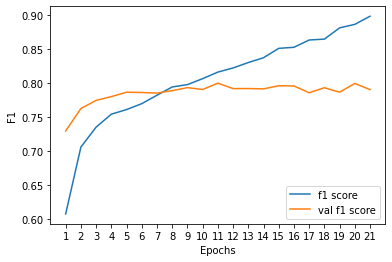

In [ ]:
#F1-score plot
plt.plot(history.history["f1_score"], label='f1 score')
plt.plot(history.history["val_f1_score"], label='val f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.ylim()
plt.xticks(np.arange(len(history.history["val_f1_score"])), np.arange(1, len(history.history["val_f1_score"])+1))
plt.legend(loc = 'lower right')

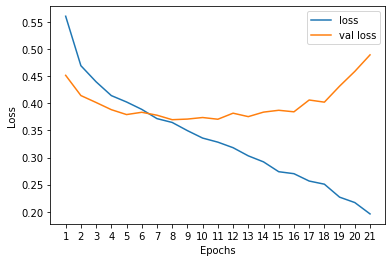

In [ ]:
#Loss plot
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim()
plt.xticks(np.arange(len(history.history["loss"])), np.arange(1, len(history.history["loss"])+1))
plt.xticks(np.arange(len(history.history["val_loss"])), np.arange(1, len(history.history["val_loss"])+1))
plt.legend(loc = 'upper right')

In [ ]:
pred_politics = best_model.predict(test_politics) > 0.5

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsTPolitics), pred_politics, digits=4))

              precision    recall  f1-score   support

           0     0.8408    0.9429    0.8889       700
           1     0.9350    0.8214    0.8745       700

    accuracy                         0.8821      1400
   macro avg     0.8879    0.8821    0.8817      1400
weighted avg     0.8879    0.8821    0.8817      1400



In [ ]:
pred_religious = best_model.predict(test_religious) > 0.5

In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsTReligious), pred_religious, digits=4))

              precision    recall  f1-score   support

           0     0.8931    0.8046    0.8466      2513
           1     0.3329    0.5031    0.4007       487

    accuracy                         0.7557      3000
   macro avg     0.6130    0.6538    0.6236      3000
weighted avg     0.8022    0.7557    0.7742      3000

